## TODO

- Using all data for initial EDA & visualizations
- Using explorative pandas profiling
- feature engineering 'Days_Since_Precipitation' column using for loop with if & else statements: if == 0, append.[0], else > 0, append.[=+1]
- Using the sampling technique Alex used for time series forecasting
- Using sci-kit learn cheat sheet throughout all this
- Once EDA is over, passing everything through reproducible functions
- Using imbalanced-learn to deal with all the zeroes
- Using only 2011 - 2020. Last 10 years. The rest, 2000 - 2010, are unnecessary for training the predictive model.

- Using separate notebook for training/tuning
- Using another notebook with pickled xgboost model for final visualizations and predictions

In [1]:
!pip install pandas-profiling==2.*

In [58]:
# Importing necessary libraries for EDA and ML

# Importing libraries for reading in our dataset and exploring it

import pandas as pd
from pandas_profiling import ProfileReport
from time import time
import datetime

# Importing libraries for linear algebra

import numpy as np
import math
import pylab
import scipy.stats as stats

# Importing libraries for creating our model

# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# #from category_encoders import OrdinalEncoder
# from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import (
#                                   LinearRegression,
#                                   Ridge,
#                                   LogisticRegression
#                                   )
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.model_selection import RandomizedSearchCV

# # Importing libraries for model metrics

# from sklearn.metrics import (
#                              accuracy_score,
#                              plot_confusion_matrix,
#                              classification_report,
#                              )

# Importing libraries for visualizations

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Need to recombine/merge my pre-split dataframes. I need to concatenate them together. This is necessary for cross validation. Having pre-split data is only good for the manual, 'hold out method', not for cross validation. The entire dataset will be used for tuning. 

I'll still do my own split with *less* data at the end. For training the Random Forest & XGBoost.

In [4]:
# Loading pre-split train, val, and testing data
filename1 = "/content/drive/MyDrive/train_timeseries.csv"
filename2 = "/content/drive/MyDrive/validation_timeseries.csv"
filename3 = "/content/drive/MyDrive/test_timeseries.csv"

df_train = pd.read_csv(filename1)
df_val = pd.read_csv(filename2)
df_test = pd.read_csv(filename3)

In [5]:
# Concatenating the pre-split data into a whole DataFrame
df = pd.concat([df_train, df_val, df_test])

In [6]:
# Sanity Check for confirming whether the concatenation worked out or noted out
train_num = df_train.shape[0]
print("Number of Observations for Pre-Split Training DataFrame: ", train_num)
print(" ")
val_num = df_val.shape[0]
print("Number of Observations for Pre-Split Validation DataFrame: ", val_num)
print(" ")
test_num = df_test.shape[0]
print("Number of Observations for Pre-Split Testing DataFrame: ", test_num)
print(" ")
complete_num = train_num + val_num + test_num
print("Number of Observations for Concatenated DataFrame: ", complete_num)
print(" ")
if df.shape[0] == complete_num:
    print("Sanity Check -  Succesful!")
else:
    ("Sanity Check - Unsuccessful!")

Number of Observations for Pre-Split Training DataFrame:  19300680
 
Number of Observations for Pre-Split Validation DataFrame:  2268840
 
Number of Observations for Pre-Split Testing DataFrame:  2271948
 
Number of Observations for Concatenated DataFrame:  23841468
 
Sanity Check -  Succesful!


In [7]:
# Sorting DF by zipcode
df.sort_values(by=["date"], inplace=True)

In [8]:
# Dealing with null values
df.isnull().sum().sum()

20435100

In [9]:
# Dropping null values from rows lacking drought scores. dont need daily drought scores, only weekly
null_mask = df.isnull() == False
df = df[null_mask]
# Rounding up the scores so we can treat this as a multi-class
# classification problem, not regression. Values need to be discrete,
# not continuous.
df['score'] = df['score'].apply(np.ceil)

# If this doesn't work well as MCC, don't round. Treat this MCC as regression.

In [ ]:
# Before any machine learning can happen, we have to read in our datasets. We have both a static soil dataset and 
# a weather timeseries dataset split in to three. This makes our job a lot easier as our work is made not only 
# accessible, but preconfigured! 

# Our validation dataset will allow us to run metric tests to compare it's scores with that of the training set.
# Having our test data separate from them ensures the tests we'll conducting with it later won't run into data
# leakage, where our training set is allowed to see what it is meant to be making predictions for. Avoiding this intereference will allow us to generalize our model so that when fed with
# any other weather timeseries data, it'll be capable of outputting reliable predictions for the near future(~up to 
# 4 weeks).

# Use this link to write more about the importance of having a validation set: 
# https://datascience.stackexchange.com/questions/76604/final-model-fitting-subset-vs-entire-training-data

# Assigning filepaths for each CSV that composes the dataset I'll be using for climatological predictive analysis

# import pandas as pd

# filepath = 'train_timeseries.csv'
# filepath2 = 'validation_timeseries.csv'
# filepath3 = 'test_timeseries.csv'

# # Reading in training data. Need a wrangle function for this. A basic read in won't do. Columns need to be
# # configured, dropped, and created while the code that executes it all can easily be ported from dataset to dataset.
# # In this case, I need the columns of our pre-split datasets to resemble each other. If it had not been pre-split, 
# # this wouldn't be necessary, other than for the sake of reproducibility.

# def wrangle(filepath):
    
    
#     # Dropping columns from soil_dataset. We only need fips and lat/long. We're doing this to merging latitude
#     # and longitude features onto our time series dataset by the fips column for visualization later on
    
    
#     df = pd.read_csv(filepath,
#                     parse_dates=['date'],
#                     index_col = 'date'
#                     )
    
    
#     # NANs in our target column are present due to the fact that our dataset creator took weekly drought scores 
#     # calculated from another weather department and matched those with daily weather data he obtained from NASA.
    
#     # We'll be interpolating these missing values by time. Averages inbetween already accounted for weekly
#     # drought scores will be used to fill in the daily scores between them.
    
#     # Seeing as there isn't a drought score provided for the first three entries, there is no way to interpolate 
#     #them with the scores provided later on. We'll have to drop them.
    
    
#     #df['score'].interpolate(
#                             #method='time',    # The interpolation is done with using our date index
#                             #limit=None, 
#                             #axis=0,           # Running the interpolation by rows, not columns
#                             #inplace=True
#                             #)
    
#     # The interpolation we applied in our wrangle function was a success. Now only the first three weather
#     # observations are missing a daily drought score. However, we must still drop these three remaining NaN 
#     # values as our baseline prediction score down below won't accept them. 
    
   
#     # We're now missing the first three days of 2000. Other than those dates, every day from 2000 to 2020
#     # are recorded.
    
    
    
    
#     #making everything weekly and rounding to full integers for mcc
#     df.dropna(0, how='any', inplace=True)
#     df['score'] = df['score'].apply(np.ceil)
    

#     #Feature engineering both rolling and lag features
   
    
#     return df
    
# # Applying our wrangle function to our pre-split weather dataset

# df = wrangle(filepath)
# df2 = wrangle(filepath2)
# df3 = wrangle(filepath3)

When attempting to set a multi-level index for both our 'fips' and date 'columns', while also interpolating our 
'score' columns' observations, this error was encountered:
ValueError: Only `method=linear` interpolation is supported on MultiIndexes.
    
We'll have to merge our two datasets together by the 'fips' column without it serving as one our indexes

## Dataset Dictionary

- **PRECTOT** - Precipitation (*mm day-1*)
- **PS** - Surface Pressure (*kPa*)
- **TS** - Earth Skin Temperature (*C*) 
- **T2M** - Temperature at 2 Meters (*C*)
- **T2M_MIN** - Minimum Temperature at 2 Meters (*C*)  
- **T2M_MAX** - Maximum Temperature at 2 Meters (*C*)
- **T2M_RANGE** - Temperature Range at 2 Meters (*C*)   
- **T2MDEW** - Dew/Frost Point at 2 Meters (*C*) 
- **T2MWET** - Wet Bulb Temperature at 2 Meters (*C*) 
- **WS10M** - Wind Speed at 10 Meters (*m/s*)
- **WS10M_MIN** - Minimum Wind Speed at 10 Meters (*m/s*)
- **WS10M_MAX** - Maximum Wind Speed at 10 Meters (*m/s*)
- **WS10M_RANGE** - Wind Speed Range at 10 Meters (*m/s*)
- **WS50M** - Wind Speed at 50 Meters (*m/s*)
- **WS50M_MIN** - Minimum Wind Speed at 50 Meters (*m/s*)
- **WS50M_MAX** - Maximum Wind Speed at 50 Meters (*m/s*)
- **WS50M_RANGE** - Wind Speed Range at 50 Meters (*m/s*) 
- **QV2M** - Specific Humidity at 2 Meters (*g/kg*) 

## Data Dictionary for Soil Data
- **fips**: US county FIPS code. *See*: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
- **lat**: Latitude
- **lon**: Longitude
- **elevation**: Median elevation (meters)
- **slope1**: 0 % ≤ slope ≤ 0.5 %
- **slope2**: 0.5 % ≤ slope ≤ 2 %
- **slope3**: 2 % ≤ slope ≤ 5 %
- **slope4**: 5 % ≤ slope ≤ 10 %
- **slope5**: 10 % ≤ slope ≤ 15 %
- **slope6**: 15 % ≤ slope ≤ 30 %
- **slope7**: 30 % ≤ slope ≤ 45 %
- **slope8**: Slope > 45 %
- **aspectN**: North: 0˚< aspect ≤45˚ or 315˚< aspect ≤360˚
- **aspectE**: East: 45˚ < aspect ≤ 135˚
- **aspectS**: South: 135˚ < aspect ≤ 225˚
- **aspectW**: West: 225˚ < aspect ≤ 315˚
- **aspectUnknown**: Undefined: Slope aspect undefined; this value is used for grids where slope gradient is undefined or slope
- **WAT_LAND**: Mapped Water Bodies
- **NVG_LAND**: Barren/Very Sparsely Vegetated Land
- **URB_LAND**: Built-Up Land (Residential & Infrastructure)
- **GRS_LAND**: Grass/Scrub/Woodland
- **FOR_LAND**: Forest Land, Calibrated to FRA2000 Land Statistics
- **CULTRF_LAND**: Rain Fall Cultivated Land, According to GMIA 4.0
- **CULTIR_LAND**: Irrigated Cultivated Land, According to GMIA 4.0
- **CULT_LAND**: Total Cultivated Land
- **SQ1**: Nutrient Availability
- **SQ2**: Nutrient Retention Capacity
- **SQ3**: Rooting Conditions
- **SQ4**: Oxygen Availability to Roots
- **SQ5**: Excess Salts
- **SQ6**: Toxicity
- **SQ7**: Workability (Constraining Field Management)

In [10]:
# Reading in our soil dataset

filepath_extra = '/content/drive/MyDrive/soil_data.csv'

df_soil = pd.read_csv(filepath_extra)
df_soil
#might have to parse fips codes in sequential order to match up our weather timeseries dataset

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,0.0000,0.0000,0.1033,0.1859,0.2003,0.1898,0.3207,0.9974,27.940498,0.288900,2.750274,10.714703,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,0.0000,0.0000,0.1415,0.2379,0.2183,0.1997,0.2026,0.0000,0.000000,0.414600,2.225602,22.952839,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,0.0000,0.0000,0.1168,0.1386,0.1048,0.1282,0.5116,0.0000,0.000000,3.501000,4.972456,28.685991,59.843639,2.996914,62.840553,3,2,1,2,1,1,1
3,1007,33.015893,-87.127148,93,0.0144,0.1617,0.3714,0.3493,0.0898,0.0134,0.0000,0.0000,0.1971,0.1885,0.2279,0.2104,0.1761,0.0000,0.000000,0.228300,8.674664,89.172112,1.916593,0.008330,1.924924,3,2,1,1,1,1,1
4,1009,33.977448,-86.567246,198,0.0050,0.0872,0.2799,0.3576,0.1477,0.1037,0.0189,0.0000,0.2569,0.1503,0.2028,0.2978,0.0922,0.0000,0.000000,1.003700,8.606856,88.470047,1.891909,0.027488,1.919397,3,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,56037,41.660339,-108.875676,2085,0.0016,0.0281,0.1763,0.3554,0.2121,0.2097,0.0168,0.0000,0.3492,0.1112,0.2760,0.2339,0.0297,0.0000,32.800003,0.000000,67.199997,0.000000,0.000000,0.000000,0.000000,1,1,3,1,1,1,3
3105,56039,44.049321,-110.588102,2564,0.0003,0.0026,0.0166,0.0722,0.1489,0.5005,0.2138,0.0451,0.1741,0.3230,0.2427,0.2573,0.0029,0.0000,0.000000,0.004600,14.530160,82.542931,2.922309,0.000000,2.922309,1,1,1,1,1,1,1
3106,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,0.0003,0.0000,0.2552,0.2011,0.1525,0.3408,0.0504,0.0000,33.000000,0.000000,67.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
3107,56041,41.284726,-110.558947,2327,0.0050,0.2009,0.4063,0.1858,0.0964,0.1031,0.0025,0.0000,0.2519,0.2918,0.0507,0.1997,0.2059,0.0000,4.532186,0.024343,14.042342,69.631836,1.013702,10.755590,11.769293,1,1,2,1,1,1,2


In [11]:
# Creating a subset of our soil dataset for a merge with our weather data later on. We only need some of the 
# features included here. Slope and aspect data would only marginally help our model, while slowing down the 
# training process of our model, while the SQ columns would be better used as targets themselves. As we're only
# concerned with drought severity, these columns will also be excluded from our soil subset.

df_subset_soil = df_soil[['fips', 'lat','lon', 'elevation', 'URB_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND', 'CULT_LAND']]
df_subset_soil

,fips,lat,lon,elevation,URB_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND
0,1001,32.536382,-86.644490,63,0.288900,27.940498,0.288900,2.750274,10.714703,56.293411,1.014811,57.308224
1,1005,31.870670,-85.405456,146,0.414600,0.000000,0.414600,2.225602,22.952839,72.578804,1.828159,74.406960
2,1003,30.659218,-87.746067,52,3.501000,0.000000,3.501000,4.972456,28.685991,59.843639,2.996914,62.840553
3,1007,33.015893,-87.127148,93,0.228300,0.000000,0.228300,8.674664,89.172112,1.916593,0.008330,1.924924
4,1009,33.977448,-86.567246,198,1.003700,0.000000,1.003700,8.606856,88.470047,1.891909,0.027488,1.919397
...,...,...,...,...,...,...,...,...,...,...,...,...
3104,56037,41.660339,-108.875676,2085,0.000000,32.800003,0.000000,67.199997,0.000000,0.000000,0.000000,0.000000
3105,56039,44.049321,-110.588102,2564,0.004600,0.000000,0.004600,14.530160,82.542931,2.922309,0.000000,2.922309
3106,56043,43.878831,-107.669052,1417,0.000000,33.000000,0.000000,67.000000,0.000000,0.000000,0.000000,0.000000
3107,56041,41.284726,-110.558947,2327,0.024343,4.532186,0.024343,14.042342,69.631836,1.013702,10.755590,11.769293


---

In [12]:
# We need to merge the fips column from both our df_soil and df dataframes so that each row has a corresponding 
# latitude and longitude based on it's fips
df_merged = df.reset_index().merge(df_subset_soil, on='fips', how="left").set_index('date')

In [14]:
#Setting a multiIndex after the merge as Pandas is only capable of time method interpolation with a single index
df_merged = df_merged.reset_index().set_index(['date', 'fips'])

In [16]:
#Automated EDA of our pre-split training timeseries weather dataset

Report = ProfileReport(df_merged, minimal=True).to_notebook_iframe()
Report

Summarize dataset:   0%|          | 0/41 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Drought Score Dictionary

- **0.0**: *No Drought*
- **1.0 = D0**: *Abnormally Dry* - Going in our out of drought. Short term dryness or lingering water deficits
- **2.0 = D1**: *Moderate Drought* - Some water shortages developing or immenent. Some damage to crops and pastures
- **3.0 = D2**: *Severe Drought* - Water shortages are common. Water restrictions imposed. Likely crop and pasture losses
- **4.0 = D3**: *Extreme Drought* - Widespread water shortages and/or restrictions. Major crop/pasture losses.
- **5.0 = D4**: *Exceptional Drought* - Water emergencies emerge from shortages of water in reservoirs, streams, and wells. Exceptional and widespread crop and pasture losses.

---
# Explore data with some plots

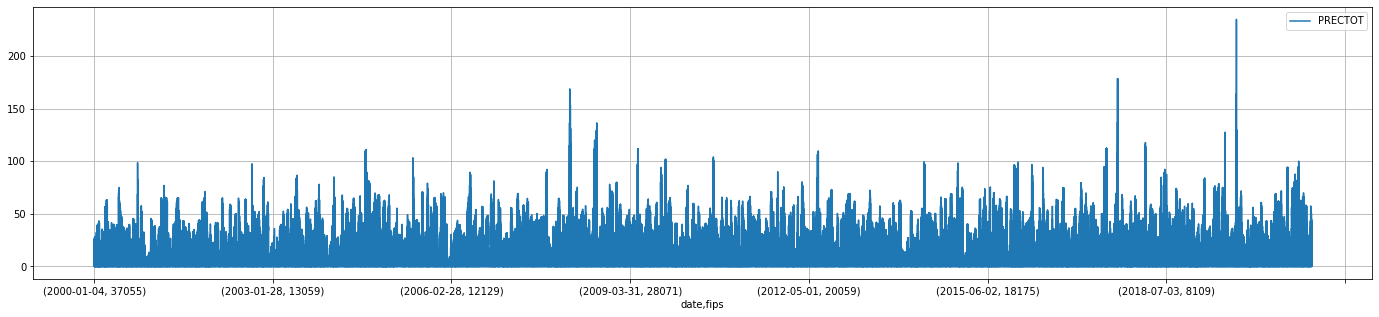

In [21]:
# Checking precipitation rate over the last 21 years
df_merged.PRECTOT.plot(figsize=(24,5), grid=True, legend=True);

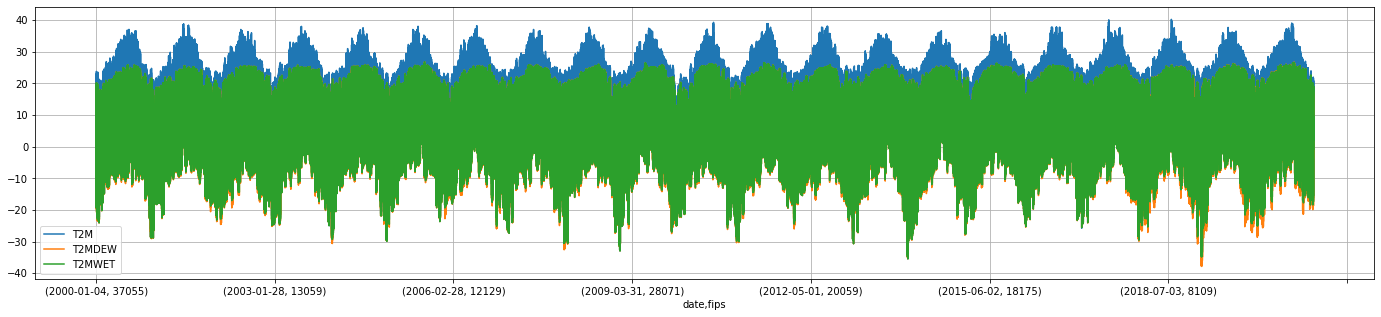

In [28]:
# Plotting temperature at 2 Meters while contrasting with temp dew and temp wetness variables
plot_temp_cols = ["T2M", "T2MDEW", "T2MWET"]
df_merged[plot_temp_cols].plot(figsize=(24,5), grid=True, legend=True);

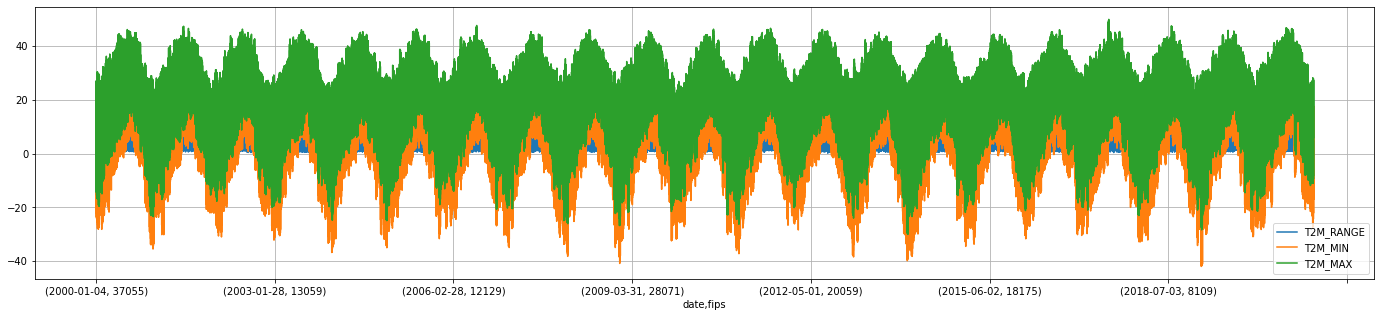

In [30]:
# Plotting temperature range while contrasting by its minimum temp and maximum temp at 2 Meters
plot_temp_cols2 = ["T2M_RANGE", "T2M_MIN", "T2M_MAX"]
df_merged[plot_temp_cols2].plot(figsize=(24,5), grid=True, legend=True);

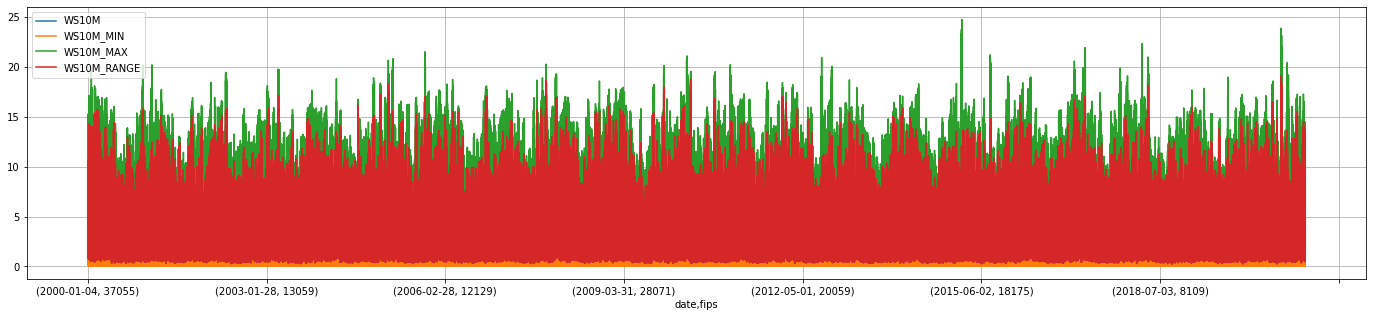

In [29]:
# Plotting wind speed at 10 MPH by min, max, and range of 10 meters
plot_wind_cols = ["WS10M", "WS10M_MIN", "WS10M_MAX", "WS10M_RANGE"]
df_merged[plot_wind_cols].plot(figsize=(24,5), grid=True, legend=True);

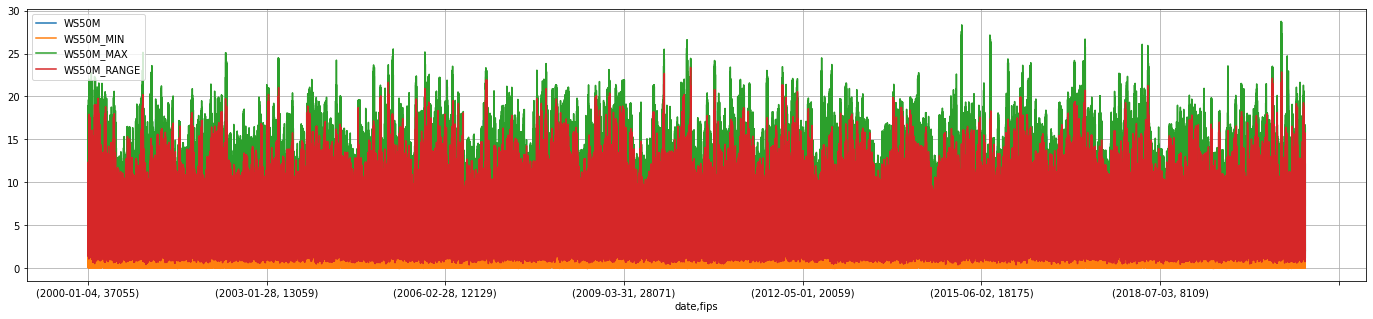

In [31]:
# Plotting wind speed at 50 MPH by min, max, and range of 50 meters
plot_wind_cols2 = ["WS50M", "WS50M_MIN", "WS50M_MAX", "WS50M_RANGE"]
df_merged[plot_wind_cols2].plot(figsize=(24,5), grid=True, legend=True);

In [34]:
# Confirming the correlation of features before we begin building our models

print(f'Correlation High to Low:\n{abs(df_merged.corr()["score"]).sort_values(ascending=False)}')

Correlation High to Low:
score          1.000000
GRS_LAND       0.241918
lon            0.241768
T2M_RANGE      0.219471
PS             0.215308
elevation      0.208836
NVG_LAND       0.134430
T2M_MAX        0.119340
CULTRF_LAND    0.114527
lat            0.110300
TS             0.086776
FOR_LAND       0.086662
CULT_LAND      0.085590
T2M            0.079515
CULTIR_LAND    0.079046
WS10M_RANGE    0.072916
T2MDEW         0.069963
T2MWET         0.068600
QV2M           0.061674
PRECTOT        0.060865
WS50M_RANGE    0.059022
WS10M_MAX      0.047988
URB_LAND       0.047253
URB_LAND       0.047253
T2M_MIN        0.047245
index          0.040948
WS50M_MIN      0.029471
WS10M          0.026719
WS50M_MAX      0.023498
WS10M_MIN      0.012416
WS50M          0.002331
Name: score, dtype: float64


These features aren't all that correlated. What to do?

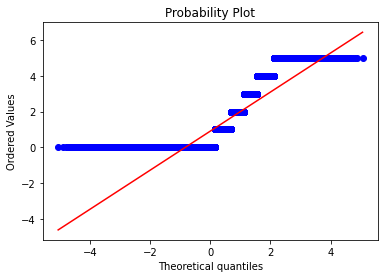

In [37]:
# Probability plot for weekly drought scores
stats.probplot(df['score'], dist="norm", plot=pylab)
pylab.show()

These are discrete values, so this plot is displaying it's probabilities correctly, however, 0 & 5, the most extreme values, are most probable.

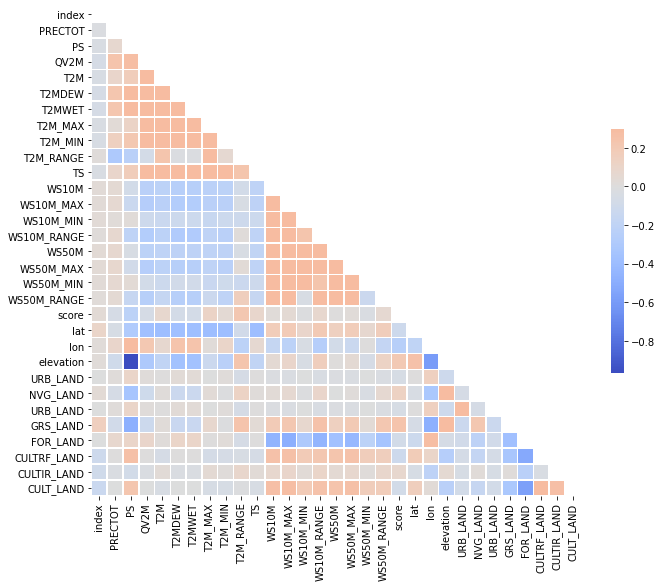

In [38]:
# plotting feature correlations 

# Computing the correlation matrix
corr = df_merged.corr()

# Generating a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [48]:
# Creating correlation threshold to filter out features with low correlations with score column
corr_threshold = 0.05
# Create correaltion mask
corr_mask = corr.score.abs()>= corr_threshold
# save surviving features to variable
keep_features = corr.score[corr_mask].index
# Mask column in dataframe
drought = df_merged[keep_features]
### We then turn this code cell into this function below to make it reproducible!!  ###

In [43]:
# How many features we began with
df_merged.shape

(3406368, 31)

In [49]:
# How many features we're left with
drought.shape

(3406368, 21)

In [50]:
# The features that remain, plus our target.
drought.columns

Index(['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_RANGE', 'TS', 'WS10M_RANGE', 'WS50M_RANGE', 'score', 'lat', 'lon',
       'elevation', 'NVG_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND',
       'CULTIR_LAND', 'CULT_LAND'],
      dtype='object')

In [51]:
def scale_data(df):
    """
    Scale time series features, save the scaler function for each feature in a look up dict for inverse scaling post model training. 
    
    Parameters
    ----------
    df: pandas dataframe
    
    Returns
    -------
    df: pandas datafarme 
        Contains scaled features
        
    scaler_dict: dict 
        look up for feature scaler objects 
        key: column name
        value: column scaler 
    """
    
    # use to save the column scaler functions
    scaler_dict = {} 
    
    # use to save the scaled column data
    scaled_data = {} 
    
    for col in df.columns:
        
        # instantiate the scaler class 
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # reshape to avoid shape errors
        feat = df[col].values.reshape(-1, 1)
        
        # scale data
        # DATA LEAKAGE! Scaler should only be fitted to training data
        # train test split should have been done prior to scaling
        col_scaled = scaler.fit_transform(feat)
        
        # save scaled column data to column key
        scaled_data[col] = col_scaled.flatten()
        
        # save scaler function to column key 
        scaler_dict[col] = scaler
        
    # move scaled data from dict to dataframe
    df_scaled = pd.DataFrame.from_dict(scaled_data)
    
    return df_scaled, scaler_dict

In [56]:
# scaling data 
df_scaled, scaler_dict = scale_data(drought)

In [57]:
scaler_dict

{'CULTIR_LAND': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'CULTRF_LAND': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'CULT_LAND': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'FOR_LAND': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'GRS_LAND': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'NVG_LAND': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'PRECTOT': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'PS': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'QV2M': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'T2M': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'T2MDEW': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'T2MWET': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'T2M_MAX': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'T2M_RANGE': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'TS': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'WS10M_RANGE': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'WS50M_RANGE': MinMaxScaler(copy=True, feature_range=(0

In [64]:
# Exporting CSV for Ensemble Learning
df_scaled.to_csv('drought_scaled_dataframe.csv')

---
# Cutting it off here

In [ ]:
# Data is pre-split into training, validation, and test. This allows us to label our variables with ease.
# (Won't be using cross validation considering we're handling a time series dataset)

target = 'score'
y_train = merged_df_train[target]
X_train = merged_df_train.drop(target, axis=1)

target2 = 'score'
y_val = merged_df_val[target2]
X_val = merged_df_val.drop(target2, axis=1)

target3 = 'score'
y_test = merged_df_test[target3]
X_test = merged_df_test.drop(target3, axis=1)

In [ ]:
merged_df_test

,,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,lon,elevation,URB_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND
date,fips,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1001,2.25,100.51,9.69,14.71,13.55,13.52,17.38,10.92,6.46,14.63,...,-86.644490,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224
2019-01-08,1001,0.05,100.57,8.75,13.15,12.01,11.98,20.04,9.36,10.68,13.05,...,-86.644490,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224
2019-01-15,1001,0.00,101.07,4.04,3.91,0.94,0.96,9.40,1.02,8.38,3.91,...,-86.644490,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224
2019-01-22,1001,0.03,101.14,4.96,6.03,3.81,3.08,12.43,-1.63,14.06,6.08,...,-86.644490,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224
2019-01-29,1001,5.79,100.36,3.69,2.23,-0.41,-1.03,7.33,-5.19,12.52,2.18,...,-86.644490,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,56043,1.24,83.55,2.58,-2.42,-7.58,-5.00,0.38,-6.79,7.17,-2.74,...,-107.669052,1417,0.0000,33.000000,0.0000,67.000000,0.000000,0.000000,0.000000,0.000000
2020-12-08,56043,0.00,83.70,2.05,1.32,-10.65,-4.67,8.08,-3.27,11.35,-1.57,...,-107.669052,1417,0.0000,33.000000,0.0000,67.000000,0.000000,0.000000,0.000000,0.000000
2020-12-15,56043,0.14,82.90,2.04,-5.19,-10.64,-7.91,0.29,-8.63,8.93,-6.81,...,-107.669052,1417,0.0000,33.000000,0.0000,67.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
X_test=X_test.reset_index().set_index(['date', 'fips'])
X_test

,,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,elevation,URB_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,y_predict
date,fips,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1001,2.25,100.51,9.69,14.71,13.55,13.52,17.38,10.92,6.46,14.63,...,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,0.142440
2019-01-08,1001,0.05,100.57,8.75,13.15,12.01,11.98,20.04,9.36,10.68,13.05,...,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,0.118641
2019-01-15,1001,0.00,101.07,4.04,3.91,0.94,0.96,9.40,1.02,8.38,3.91,...,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,0.095998
2019-01-22,1001,0.03,101.14,4.96,6.03,3.81,3.08,12.43,-1.63,14.06,6.08,...,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,0.088287
2019-01-29,1001,5.79,100.36,3.69,2.23,-0.41,-1.03,7.33,-5.19,12.52,2.18,...,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,0.099416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,56043,1.24,83.55,2.58,-2.42,-7.58,-5.00,0.38,-6.79,7.17,-2.74,...,1417,0.0000,33.000000,0.0000,67.000000,0.000000,0.000000,0.000000,0.000000,0.179966
2020-12-08,56043,0.00,83.70,2.05,1.32,-10.65,-4.67,8.08,-3.27,11.35,-1.57,...,1417,0.0000,33.000000,0.0000,67.000000,0.000000,0.000000,0.000000,0.000000,0.131169
2020-12-15,56043,0.14,82.90,2.04,-5.19,-10.64,-7.91,0.29,-8.63,8.93,-6.81,...,1417,0.0000,33.000000,0.0000,67.000000,0.000000,0.000000,0.000000,0.000000,0.168286


In [ ]:
# Confirming that the feature matrix/target vector split for all three sets was successful

print('Number of features in train FM:', X_train.shape)
print('Number of features in val FM:', X_val.shape)
print('Number of features in test FM:', X_test.shape)

Number of features in train FM: (2756796, 30)
Number of features in val FM: (323232, 30)
Number of features in test FM: (326340, 30)


In [ ]:
# Have a multiclass classification problem. Drought score is found within a range of 0 - 5.

baseline = y_train.value_counts(normalize=True).max()
print('MultiClass Classification Baseline Is:', baseline)

# Our MCC baseline is performing worse than a random guess(50/50 chance of getting it right)

MultiClass Classification Baseline Is: 0.5371550887334428


In [ ]:
# This wont due. I want to predict for minority-classes greater than 0. This baseline is returning the majority class of 0s, which represent no drought.
# Obviously most regions in the US aren't experiencing drought, but what do I predict for those that are in when 
# my baseline consists of the percentage of our majority class(0 = no drought) instead of our minority 
# classes(1-5 = severity of drought)? 

# I'll have to treat my multiclassification problem as a regression problem, considering floats exist between each
# class anyway. (ex. 0.827272, 1.472829, 2.3138399, 3.89384374, 4.9999173, etc.) My classes are not discrete,
# but continuous.  

# Using this link here to explain in the blog why I'm treating a MCC as Regression:
# https://e2eml.school/five_questions_data_science_answers.html

y_pred = [y_train.mean()] * len(y_train)

baseline_mae = mean_absolute_error(y_train, y_pred)

print('Regression Baseline Is:', baseline_mae)

# As we can see by this score, treating this multiclass classification problem as regression isn't the way to go

Regression Baseline Is: 1.0439922803512682


In [ ]:
# Before we begin with our first ensemble method model, random forest, let's get an idea of how it's trees work.
# Can't graph a random forest. For what is a forest, but it's trees?

from sklearn.tree import DecisionTreeClassifier

# Creating a pipeline with an encoder for our classificatory values in order to fit our model to a decision tree

model_dt = DecisionTreeClassifier(random_state=52)

model_tree = model_dt.fit(X_train, y_train)

In [ ]:
!pip install dtreeviz

In [ ]:
from dtreeviz.trees import dtreeviz

# Visualizing a Decision Tree

viz = dtreeviz(
               model_tree, 
               X_train, 
               y_train,
               target_name="score",
               feature_names=X_train.columns)

#Let's take a look under the bag, shall we?
viz

In [ ]:
# Building Random Forest (which is also an ensemble bagging model. A Meta-Inductive Model)

# Models may need a pipeline in order to ____
# When building a pipeline for a model, we must choose certain paramters, such as encoders, imputers, and scalers. These are for ____

# OneHotEncoder transforms categorical features into integers.
# An OrdinalEncoder would be used to transform categorical features into integers. We aren't treating this MMC problem as such, but
# as a regression problem.
# A SimpleImputer for filling missing values. As we don't have any missing values, this will not be needed.
# A DecisionTreeRegressor as our predictor, the most crucial paramter in the pipeline of our model.
# StandardScaler is used to rescale all features by removing their mean and scaling to each observations standard deviation. We use
# it if we wish to have a normal distribution.

model_rf = make_pipeline(
                         OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestClassifier(
                                                class_weight = 'balanced_subsample',
                                                n_estimators=100,
                                                n_jobs=-1,                       # forcing all CPU resources to train this model
                                                random_state=52,                #
                                                max_depth=70,
                                                verbose=10                       # 
                                                ))

model_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100building tree 19 of 100
building tree 20 of 100
building tree 21 of 100

building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.0s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100building tree 28 of 100

building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.1min


building tree 34 of 100building tree 35 of 100

building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.1min


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100building tree 52 of 100

building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.6min


building tree 56 of 100building tree 57 of 100
building tree 58 of 100
building tree 59 of 100

building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100building tree 72 of 100

building tree 73 of 100building tree 74 of 100

building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.2min


building tree 76 of 100building tree 77 of 100

building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  2.7min


building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100building tree 88 of 100

building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:  2.7min remaining:   41.1s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:  3.2min remaining:   19.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished


Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=70, n_jobs=-1,
                                        random_state=52, verbose=10))])

In [ ]:
# Building ensemble boosting regression model. (XGBregressor. Another Meta-Inductive Model)

model_xgb = make_pipeline(
                          OrdinalEncoder(),
                          SimpleImputer(),
                          XGBClassifier(random_state = 72,
                                       n_estimators = 20,
                                       max_depth = 70,
                                       learning_rate = 0.05,
                                       n_jobs=-1,
                                       ))

model_xgb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(learning_rate=0.05, max_depth=70,
                               n_estimators=20, n_jobs=-1,
                               objective='multi:softprob', random_state=72))])

In [ ]:
# Random Forest and XGBoost Metrics

# We're using .score as our metric because ___

print('Random Forest Model')
print('Training accuracy:', model_rf.score(X_train, y_train))
print('Validation accuracy:', model_rf.score(X_val, y_val))
print()
print('XGBoost Model')
print('Training accuracy:', model_xgb.score(X_train, y_train))
print('Validation accuracy:', model_xgb.score(X_val, y_val))

Random Forest Model


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    3.3s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    6.0s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    7.4s
[Parallel(n_jobs=16)]: Done  80 out of 100 | elapsed:    8.0s remaining:    2.0s
[Parallel(n_jobs=16)]: Done  91 out of 100 | elapsed:    9.3s remaining:    0.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   10.2s finished


Training accuracy: 1.0


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done  80 out of 100 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  91 out of 100 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished


Validation accuracy: 0.5736560736560736

XGBoost Model
Training accuracy: 0.9947036342188541
Validation accuracy: 0.5435755123255124


In [ ]:
# MAE Evaluation
model_rf_training_mae = mean_absolute_error(y_train, model_rf.predict(X_train))
model_rf_validation_mae = mean_absolute_error(y_val, model_rf.predict(X_val))

model_xgb_training_mae = mean_absolute_error(y_train, model_xgb.predict(X_train))
model_xgb_validation_mae = mean_absolute_error(y_val, model_xgb.predict(X_val))


print('Random Forest Model')
print('Training MAE:', model_rf_training_mae)
print('Validation MAE:', model_rf_validation_mae)
print()
print('XGBoost Model')
print('Training MAE:', model_xgb_training_mae)
print('Validation MAE:', model_xgb_validation_mae)

# Looks like Mean Absolute Error isn't actually a good metric for these ensemble methods. Training accuracy for 
# whatever reason is 0, while validation accuracy looks optimal.

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    3.3s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    4.7s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    6.1s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    7.5s
[Parallel(n_jobs=16)]: Done  80 out of 100 | elapsed:    8.0s remaining:    2.0s
[Parallel(n_jobs=16)]: Done  91 out of 100 | elapsed:    9.3s remaining:    0.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   10.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  40 tasks      | 

Random Forest Model
Training MAE: 0.0
Validation MAE: 0.7120396495396495

XGBoost Model
Training MAE: 0.008076767377782033
Validation MAE: 0.7720708345708346


In [ ]:
# RF Classification Report against test data
# Almost Final Test

# precision measures ___
# recall measures ____
# f1 score measures ____ and is a harmonic mean between precision and recall
# 

print(classification_report(y_val, model_rf.predict(X_val)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done  80 out of 100 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  91 out of 100 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished


              precision    recall  f1-score   support

         0.0       0.63      0.92      0.75    191773
         1.0       0.29      0.09      0.13     70695
         2.0       0.19      0.05      0.08     36653
         3.0       0.12      0.06      0.08     15694
         4.0       0.09      0.05      0.07      6591
         5.0       0.04      0.03      0.03      1826

    accuracy                           0.57    323232
   macro avg       0.23      0.20      0.19    323232
weighted avg       0.47      0.57      0.49    323232



In [ ]:
model_rf.named_steps

{'ordinalencoder': OrdinalEncoder(cols=[], mapping=[]),
 'simpleimputer': SimpleImputer(),
 'randomforestclassifier': RandomForestClassifier(class_weight='balanced_subsample', max_depth=70,
                        n_jobs=-1, random_state=52, verbose=10)}

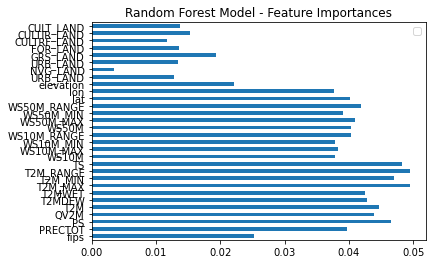

In [ ]:
# Feature Importances RF

features = model_rf.named_steps['ordinalencoder'].get_feature_names()
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_


feature_importances = pd.DataFrame(importances, index = features).plot.barh()
#plt.rcParams["figure.figsize"] = (20,10)
plt.title('Random Forest Model - Feature Importances')
plt.legend('')
plt.show();

<AxesSubplot:>

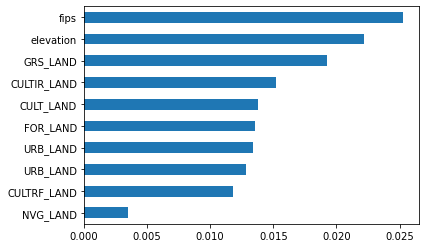

In [ ]:
# Sorted Top 15 Features that correlated with severity of drought across the US

importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = X_val.columns
pd.Series(importances, index=features).sort_values().head(10).plot(kind='barh')

In [ ]:
# Confusion Matrix for Random Forest Model against test data
# Final test

plot_confusion_matrix(model_rf, X_test, y_test)

In [ ]:
# Permutation Importances on a tuned Random Forest model

# Choosing my 'most important' feature
col_rf = 'T2M_RANGE'

# Evaluating our model fit with training data using our validation data
print('Random Forest Validation Accuracy:', model_rf.score(X_val, y_val))

# Importing necessary library
from sklearn.inspection import permutation_importance

# Step 4: In Validation data, we're permuting the feature we're evaluating
X_val_perm = X_val.copy()
X_val_perm[col_rf] = np.random.permutation(X_val_perm[col_rf])

# Calculating our error metric with permuated data
# Will always be a bit of variation dependent on how the prior rearrangement was performed
print(f'Random Forest Valdidation Accuracy Score with "{col_rf}" Permutated:', model_rf.score(X_val_perm, y_val))

# Our model's accuracy score improved somewhat. Still rather low.

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done  80 out of 100 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  91 out of 100 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished


Random Forest Validation Accuracy: 0.5736560736560736


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done  80 out of 100 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  91 out of 100 | elapsed:    1.2s remaining:    0.1s


Random Forest Valdidation Accuracy Score with "T2M_RANGE" Permutated: 0.5766167953667953


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished


In [ ]:
# Feature Importances XGB

# Choosing my 'most important' feature
col = 'T2M_RANGE'

# Evaluating our model fit with training data using our validation data
print('XGBoost Validation Accuracy:', model_xgb.score(X_val, y_val))

# In Validation data, we're permuting the feature we're evaluating
X_val_perm_xgb = X_val.copy()
X_val_perm_xgb[col] = np.random.permutation(X_val_perm_xgb[col])

# Calculating our error metric with permuated data
# Will always be a bit of variation dependent on how the prior rearrangement was performed
print(f'XGBoost Valdidation Accuracy Score with "{col}" perumted:', model_xgb.score(X_val_perm, y_val))

# Looks like our XGBoost model has taken a hit in performance after that permutation! Seems stochastic shuffling 
# of values by columns can improve one model(our RF) while disabling another.

XGBoost Validation Accuracy: 0.5435755123255124
XGBoost Valdidation Accuracy Score with "T2M_RANGE" perumted: 0.5256812444312444


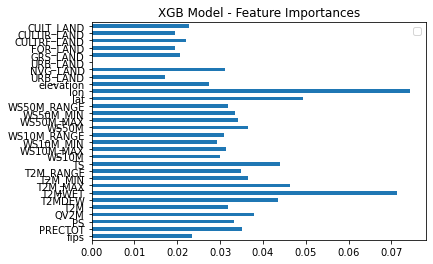

In [ ]:
# Feature Importances XGB

features_xgb = model_xgb.named_steps['ordinalencoder'].get_feature_names()
importances_xgb = model_xgb.named_steps['xgbclassifier'].feature_importances_


feature_importances_xgb = pd.DataFrame(importances_xgb, index = features_xgb).plot.barh()
#plt.rcParams["figure.figsize"] = (20,10)
plt.title('XGB Model - Feature Importances')
plt.legend('')
plt.show();

<AxesSubplot:>

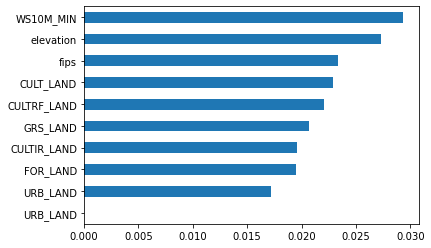

In [ ]:
importances_xgb = model_xgb.named_steps['xgbclassifier'].feature_importances_
features_xgb = X_val.columns
pd.Series(importances_xgb, index=features_xgb).sort_values().head(10).plot(kind='barh')

In [ ]:
# Testing our XGBoost model against test data
# Almost Final Test

model_cr_xgb = classification_report(y_test, model_xgb.predict(X_test))

print(model_cr_xgb)

              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79    222634
         1.0       0.24      0.14      0.18     55779
         2.0       0.15      0.10      0.12     27941
         3.0       0.11      0.11      0.11     12988
         4.0       0.08      0.11      0.09      5597
         5.0       0.01      0.02      0.01      1401

    accuracy                           0.61    326340
   macro avg       0.22      0.22      0.22    326340
weighted avg       0.57      0.61      0.59    326340



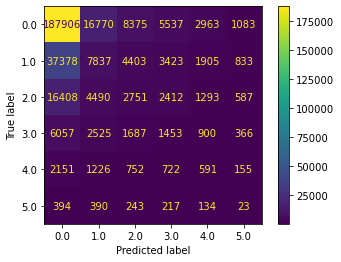

In [ ]:
# Confusion Matrix for XGBoost Model against our test set
# Final Test

plot_confusion_matrix(model_xgb, X_test, y_test)

# From here we can infer that most of the US isn't experiencing drought, while most areas that are find themselves 
# experiencing mild levels.

In [ ]:
# Setting up our severe drought map. Counties most affected by drought. Using class 4, and 'fips'

y_train.value_counts()

0.0    1480827
1.0     532931
2.0     329007
3.0     225007
4.0     132089
5.0      56935
Name: score, dtype: int64

In [ ]:
y_pred_proba = model_xgb.predict_proba(X_test)

In [ ]:
#printing the first 10 values from our numpy array

y_pred_proba[0:10]

# Interpreting the array
# Our target is (0,1,2,3,4,5), then the classifier would output a probability matrix of dimension (N,6). The first
# index refers to the probability that the data belong to class 0, and the second refers to the probability that the
# data belong to class 1, and so on to class 6.

array([[0.15786299, 0.2550934 , 0.1051722 , 0.11776411, 0.25984064,
        0.10426665],
       [0.16978732, 0.2435341 , 0.10930943, 0.23629405, 0.0919176 ,
        0.14915751],
       [0.22290118, 0.0746242 , 0.16466853, 0.0969466 , 0.35982573,
        0.08103371],
       [0.3834226 , 0.0790889 , 0.1736656 , 0.10240072, 0.1363007 ,
        0.12512152],
       [0.27213997, 0.09735091, 0.20449927, 0.1181731 , 0.16050038,
        0.14733638],
       [0.22066534, 0.22831224, 0.14557609, 0.11011161, 0.22409253,
        0.07124219],
       [0.19765213, 0.27599257, 0.116614  , 0.1388524 , 0.09791445,
        0.17297444],
       [0.3055054 , 0.11682347, 0.21835569, 0.1098143 , 0.1241501 ,
        0.12535104],
       [0.22601423, 0.20797344, 0.10822686, 0.11686796, 0.25380087,
        0.08711664],
       [0.2502829 , 0.09848367, 0.21866228, 0.11954814, 0.16236793,
        0.15065505]], dtype=float32)

In [ ]:
# Assigning class 4 drought to our y_predict column
X_test['y_predict'] = model_xgb.predict_proba(X_test)[:,-2]

In [ ]:
print(X_test['y_predict'])
# The probability values match up with those in the numpy array above. We got the right column!

date        fips 
2019-01-01  1001     0.259841
2019-01-08  1001     0.091918
2019-01-15  1001     0.359826
2019-01-22  1001     0.136301
2019-01-29  1001     0.160500
                       ...   
2020-12-01  56043    0.174181
2020-12-08  56043    0.157149
2020-12-15  56043    0.165274
2020-12-22  56043    0.177576
2020-12-29  56043    0.225120
Name: y_predict, Length: 326340, dtype: float32


In [ ]:
X_test['y_predict'].value_counts().sum()

326340

In [ ]:
# We're using probabilism as our theory of knowledge alongside this supervised machine learning model. So we can't
# just leave it at grabbing every prediction the model can generate, we're only going for the ones that our model is
# 95% sure of!
#* .95 is a stattistics convention

# Oh... Well loook at that...

# Our XGB model isn't very balanced. It's unable to garner a certainty above 50%(a random guess) for more than one column.
# Looks like supervised learning ensemble methods aren't enough to predict weather conditions. Either that or my
# hyperparamters were far from than optimal.

mask = X_test['y_predict'] > 0.55

X_test_class_four = X_test[mask].copy()

X_test_class_four

,,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,elevation,URB_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,y_predict
date,fips,,,,,,,,,,,,,,,,,,,,,


In [ ]:
!pip install plotly

In [ ]:
X_test

,,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,elevation,URB_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,y_predict
date,fips,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1001,2.25,100.51,9.69,14.71,13.55,13.52,17.38,10.92,6.46,14.63,...,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,0.259841
2019-01-08,1001,0.05,100.57,8.75,13.15,12.01,11.98,20.04,9.36,10.68,13.05,...,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,0.091918
2019-01-15,1001,0.00,101.07,4.04,3.91,0.94,0.96,9.40,1.02,8.38,3.91,...,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,0.359826
2019-01-22,1001,0.03,101.14,4.96,6.03,3.81,3.08,12.43,-1.63,14.06,6.08,...,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,0.136301
2019-01-29,1001,5.79,100.36,3.69,2.23,-0.41,-1.03,7.33,-5.19,12.52,2.18,...,63,0.2889,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,0.160500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,56043,1.24,83.55,2.58,-2.42,-7.58,-5.00,0.38,-6.79,7.17,-2.74,...,1417,0.0000,33.000000,0.0000,67.000000,0.000000,0.000000,0.000000,0.000000,0.174181
2020-12-08,56043,0.00,83.70,2.05,1.32,-10.65,-4.67,8.08,-3.27,11.35,-1.57,...,1417,0.0000,33.000000,0.0000,67.000000,0.000000,0.000000,0.000000,0.000000,0.157149
2020-12-15,56043,0.14,82.90,2.04,-5.19,-10.64,-7.91,0.29,-8.63,8.93,-6.81,...,1417,0.0000,33.000000,0.0000,67.000000,0.000000,0.000000,0.000000,0.000000,0.165274


In [ ]:
X_test['y_predict']

date        fips 
2019-01-01  1001     0.259841
2019-01-08  1001     0.091918
2019-01-15  1001     0.359826
2019-01-22  1001     0.136301
2019-01-29  1001     0.160500
                       ...   
2020-12-01  56043    0.174181
2020-12-08  56043    0.157149
2020-12-15  56043    0.165274
2020-12-22  56043    0.177576
2020-12-29  56043    0.225120
Name: y_predict, Length: 326340, dtype: float32

EXPORTING OUR DATA TO .CSV SO THAT WE MAY LOAD INTO A NEW NOTEBOOK AND PLOT OUT OUR PREDICTIONS

In [ ]:
# Exporting our predictions!

exported_predictions = pd.DataFrame(X_test['y_predict'])
exported_predictions

,,y_predict
date,fips,
2019-01-01,1001,0.259841
2019-01-08,1001,0.091918
2019-01-15,1001,0.359826
2019-01-22,1001,0.136301
2019-01-29,1001,0.160500
...,...,...
2020-12-01,56043,0.174181
2020-12-08,56043,0.157149
2020-12-15,56043,0.165274


In [ ]:
exported_predictions.to_csv('drought_predictions.csv')

In [ ]:
# Plotly Scatterbox Map of the US with TM2_Range by lat & long





In [ ]:
# Using both Mean Absolute Error and Root Mean Squared Error for my evaluation metrics for my models.

# RMSE penalizes predictions that are way off the mark

# MAE tells us how far off our prediction was by treating all prediction errors proportionately 

# MAE is the easiest to understand, yet comes sup short when evaluating disporportionately high scores, for that RMSE
# can make up where MAE failed us



In [ ]:
#Shapley Plot visualization 
import shap

row = X_val.head(1)

explainer = shap.TreeExplainer(model_gb)  
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
                base_value = explainer.expected_value,
                shap_values = shap_values,
                features = row
                )